# Experiment 2-3
- 결측치가 많은 `occyp_type` drop
- 이외 2와 동일
  

In [ ]:
from urllib.request import urlretrieve

urlretrieve('https://drive.google.com/uc?export=download&id=1XLVFI_sK0smRVVuT8XU2s-M3lJT-68sN', './open.zip')

('./open.zip', <http.client.HTTPMessage at 0x7f2cd99b7250>)

In [ ]:
!unzip ./open.zip

Archive:  ./open.zip
replace open/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: open/train.csv          
  inflating: open/sample_submission.csv  
  inflating: open/test.csv           


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import cross_validate

In [ ]:
train = pd.read_csv('./open/train.csv')
test = pd.read_csv('./open/test.csv')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [ ]:
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


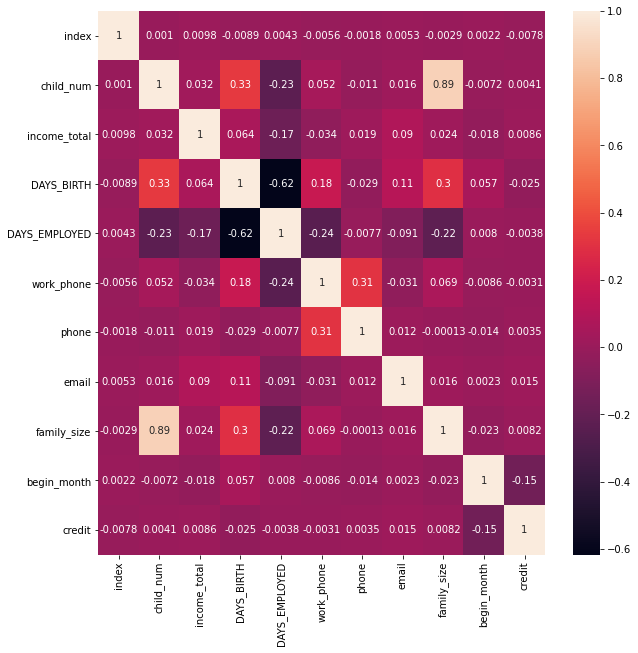

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(train.drop('FLAG_MOBIL', axis=1).corr(), annot=True)

## Data Preprocessing

In [ ]:
train.fillna('NAN', inplace=True) 
test.fillna('NAN', inplace=True)

In [ ]:
train.drop('index', axis=1, inplace=True)
test.drop('index', axis=1, inplace=True)

In [ ]:
train.drop('FLAG_MOBIL', axis=1, inplace=True)
test.drop('FLAG_MOBIL', axis=1, inplace=True)A

In [ ]:
train.drop('occyp_type', axis=1, inplace=True)
test.drop('occyp_type', axis=1, inplace=True)

In [ ]:
binary_col = ['gender',
              'car',
              'reality']

binary_encoder = OrdinalEncoder(categories=[['F', 'M'],
                                            ['N', 'Y'],
                                            ['N', 'Y']],
                                dtype=np.int8)\
                              .fit(train.loc[:,binary_col])

train.loc[:,binary_col] = binary_encoder.transform(train.loc[:,binary_col])

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   gender         26457 non-null  int64  
 1   car            26457 non-null  int64  
 2   reality        26457 non-null  int64  
 3   child_num      26457 non-null  int64  
 4   income_total   26457 non-null  float64
 5   income_type    26457 non-null  object 
 6   edu_type       26457 non-null  object 
 7   family_type    26457 non-null  object 
 8   house_type     26457 non-null  object 
 9   DAYS_BIRTH     26457 non-null  int64  
 10  DAYS_EMPLOYED  26457 non-null  int64  
 11  work_phone     26457 non-null  int64  
 12  phone          26457 non-null  int64  
 13  email          26457 non-null  int64  
 14  family_size    26457 non-null  float64
 15  begin_month    26457 non-null  float64
 16  credit         26457 non-null  float64
dtypes: float64(4), int64(9), object(4)
memory usage: 3

In [ ]:
onehot_col = ['income_type',
              'edu_type',
              'family_type',
              'house_type']
#               'occyp_type'

onehot_encoder = OneHotEncoder()
onehot_encoder.fit(train.loc[:,onehot_col])


train_onehot_df = pd.DataFrame(onehot_encoder.transform(train.loc[:,onehot_col]).toarray(), 
             columns=onehot_encoder.get_feature_names(onehot_col))
train.drop(onehot_col, axis=1, inplace=True)
train = pd.concat([train, train_onehot_df], axis=1)

In [ ]:
X_train = train.drop('credit', axis=1)
y_train = train['credit']

## modeling

In [ ]:
scores = cross_validate(LGBMClassifier(), X_train, y_train,
                        scoring='neg_log_loss', return_train_score = True)
scores

{'fit_time': array([0.892874  , 0.85678935, 0.8990624 , 0.86303091, 0.86400366]),
 'score_time': array([0.056638  , 0.06030655, 0.0602963 , 0.05810738, 0.05749059]),
 'test_score': array([-0.76038007, -0.76325093, -0.76418352, -0.76390333, -0.76288668]),
 'train_score': array([-0.68271793, -0.68033032, -0.68001218, -0.68174537, -0.67919616])}

In [ ]:
np.mean(scores['test_score'])

-0.7629209081254806